# Análisis de preguntas similares

## 1. Importación de librerías

In [1]:
# Generales
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Tensorflow y Keras
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Carga del csv y configuración de parámetros principales

In [2]:
# Parámetros configurables
N = 60  # Número de palabras del diccionario
T = 60    # Longitud prefijada de la reseña
D = 60
EPOCHS = 10
NEURONAS = 64

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

datos = pd.read_csv("/kaggle/input/preguntas/preguntas.csv")

In [3]:
datos.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
datos['question1'].apply(len).mean()

59.494476666666664

In [5]:
datos.drop(["id", "qid1", "qid2"], axis=1, inplace=True)

In [6]:
datos.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
def get_dictionary(text, sw, N):
    vectorizer = CountVectorizer(stop_words=sw, max_features=N)
    vectorizer.fit_transform(text)
    dictionary = vectorizer.vocabulary_
    dictionary = {word: i + 2 for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary['DESC'] = 0
    dictionary['PAD'] = 1
    return dictionary

In [8]:
def text_to_sequence(text, dictionary, stop_words, T):
    palabras = re.findall(r'[^a-z\s]', text.lower()) #Tokenizar
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    secuencia = [dictionary.get(palabra, dictionary['DESC']) for palabra in palabras]
    secuencia = secuencia[:T]
    secuencia += [dictionary['PAD']] * (T - len(secuencia))
    return np.array(secuencia)

In [9]:
# Variable objetivo
y = datos.iloc[:, -1]
num_clases = len(y.unique())
# Codificamos con "one hot" las posibles categorías finales
# y = pd.get_dummies(datos['is_duplicate'], columns=['is_duplicate'])

datos["preguntas"] = datos["question1"] + datos["question2"]

# Textos de reseñas
textos = datos['preguntas']
X = []
diccionario = get_dictionary(textos, stop_words, N)
for texto in textos:
    X.append(text_to_sequence(texto, diccionario, stop_words, T))
# X contendrá las reseñas codificadas y rellenas con la misma longitud
X = np.array(X)

In [10]:
datos.head()

,question1,question2,is_duplicate,preguntas
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."


In [11]:
textos = datos['preguntas']
X = pad_sequences(textos.apply(lambda t: text_to_sequence(t, diccionario, stop_words, T)), maxlen=T, padding='post')  # T debe ser la longitud deseada (ej: 100)
y = datos['is_duplicate']

In [12]:
y

0         0
1         0
2         0
3         0
4         0
         ..
299995    0
299996    0
299997    1
299998    0
299999    0
Name: is_duplicate, Length: 300000, dtype: int64

In [13]:
datos.head()

,question1,question2,is_duplicate,preguntas
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."


In [14]:
print("X", X.shape)
print("y", y.shape)

X (300000, 60)
y (300000,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [16]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (240000, 60)
y_train (240000,)
X_test (60000, 60)
y_test (60000,)


In [17]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 60, 60)              │           3,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 60, 128)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,369 (747.54 KB)

 Trainable params: 191,369 (747.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=64, verbose=1)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 65s 20ms/step - accuracy: 0.6284 - loss: 0.6450 - val_accuracy: 0.6271 - val_loss: 0.6409
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6259 - loss: 0.6425 - val_accuracy: 0.6271 - val_loss: 0.6405
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6283 - loss: 0.6403 - val_accuracy: 0.6271 - val_loss: 0.6410
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.6278 - loss: 0.6410 - val_accuracy: 0.6271 - val_loss: 0.6425
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6271 - loss: 0.6408 - val_accuracy: 0.6271 - val_loss: 0.6415
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6286 - loss: 0.6401 - val_accuracy: 0.6271 - val_loss: 0.6404
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6272 - loss: 0.6406 - val_accuracy: 0.6271 - val_loss: 0.6401
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.6276 -

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

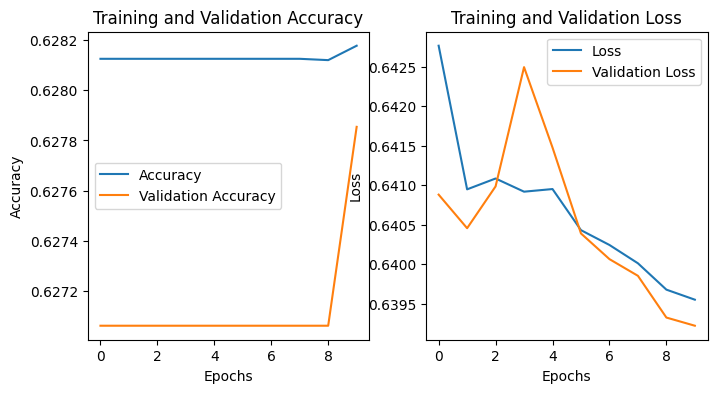

In [20]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

No Duplicado       0.63      0.99      0.77     37828
   Duplicado       0.57      0.01      0.03     22172

    accuracy                           0.63     60000
   macro avg       0.60      0.50      0.40     60000
weighted avg       0.61      0.63      0.50     60000



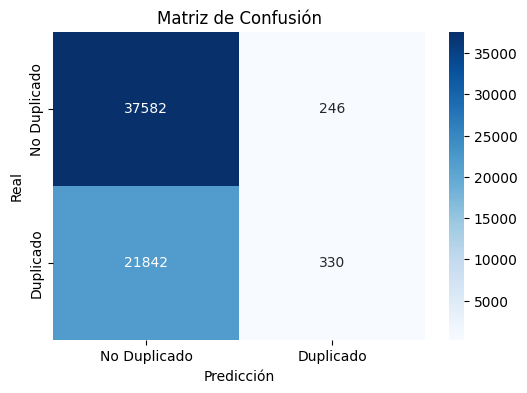

In [21]:
def train_validation(model, X_test, y_test):
   
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Duplicado", "Duplicado"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Duplicado", "Duplicado"],
                yticklabels=["No Duplicado", "Duplicado"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

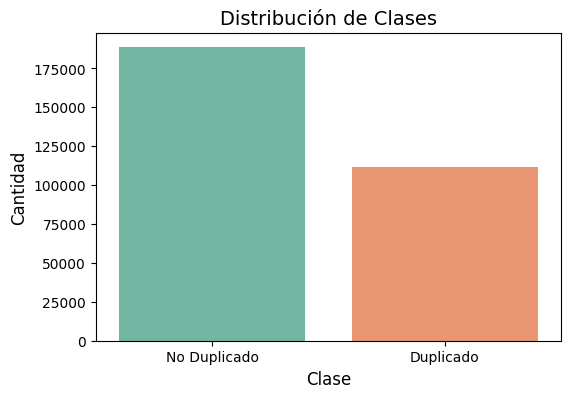

In [22]:
# Supongamos que la columna de clases es 'is_duplicate'
plt.figure(figsize=(6,4))
sns.countplot(data=datos, x='is_duplicate', palette='Set2')

# Etiquetas y título
plt.title("Distribución de Clases", fontsize=14)
plt.xlabel("Clase", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()

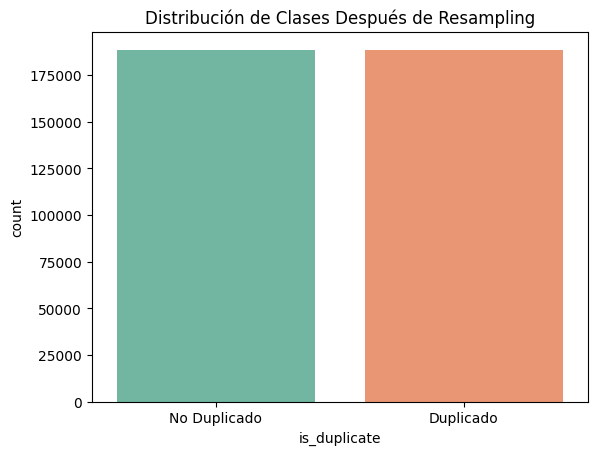

In [23]:
from sklearn.utils import resample

# Separar las clases
clase_mayoritaria = datos[datos['is_duplicate'] == 0]
clase_minoritaria = datos[datos['is_duplicate'] == 1]

# Hacer oversampling de la clase minoritaria
clase_minoritaria_aumentada = resample(
    clase_minoritaria,
    replace=True,                      # muestreo con reemplazo
    n_samples=len(clase_mayoritaria), # igualar al número de la clase mayoritaria
    random_state=42
)

# Combinar para tener un dataset balanceado
datos_balanceado = pd.concat([clase_mayoritaria, clase_minoritaria_aumentada])

# Barajar las filas
datos_balanceado = datos_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar nuevo balance
sns.countplot(data=datos_balanceado, x='is_duplicate', palette='Set2')
plt.title("Distribución de Clases Después de Resampling")
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()


In [24]:
datos_balanceado.head()

,question1,question2,is_duplicate,preguntas
0,What is Netflix? How does it work? How much do...,Is Netflix worth the cost?,0,What is Netflix? How does it work? How much do...
1,What is the future of internet piracy?,What is the most likely future of internet pir...,1,What is the future of internet piracy?What is ...
2,What's the most embarrassing moment of your life?,What is your most embarrassing moment ever?,1,What's the most embarrassing moment of your li...
3,Can we donate blood after getting a tattoo?,Can we donate blood after tattoo?,1,Can we donate blood after getting a tattoo?Can...
4,"I'm planning on exercising quite a lot, as wel...",I'm going to stop eating and drinking anything...,1,"I'm planning on exercising quite a lot, as wel..."


In [25]:
textos = datos_balanceado['preguntas']
X = pad_sequences(textos.apply(lambda t: text_to_sequence(t, diccionario, stop_words, T)), maxlen=T, padding='post')  # T debe ser la longitud deseada (ej: 100)
y = datos_balanceado['is_duplicate']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [30]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 60, 60)              │           3,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 60, 128)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,369 (747.54 KB)

 Trainable params: 191,369 (747.54 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=64, verbose=1)

Epoch 1/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - accuracy: 0.5828 - loss: 0.6754 - val_accuracy: 0.5885 - val_loss: 0.6708
Epoch 2/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.5891 - loss: 0.6716 - val_accuracy: 0.5895 - val_loss: 0.6707
Epoch 3/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - accuracy: 0.5891 - loss: 0.6715 - val_accuracy: 0.5875 - val_loss: 0.6705
Epoch 4/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - accuracy: 0.5884 - loss: 0.6709 - val_accuracy: 0.5890 - val_loss: 0.6703
Epoch 5/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - accuracy: 0.5893 - loss: 0.6712 - val_accuracy: 0.5887 - val_loss: 0.6708
Epoch 6/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.5908 - loss: 0.6699 - val_accuracy: 0.5895 - val_loss: 0.6705
Epoch 7/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 76s 20ms/step - accuracy: 0.5914 - loss: 0.6700 - val_accuracy: 0.5895 - val_loss: 0.6699
Epoch 8/10
3771/3771 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.5937 -

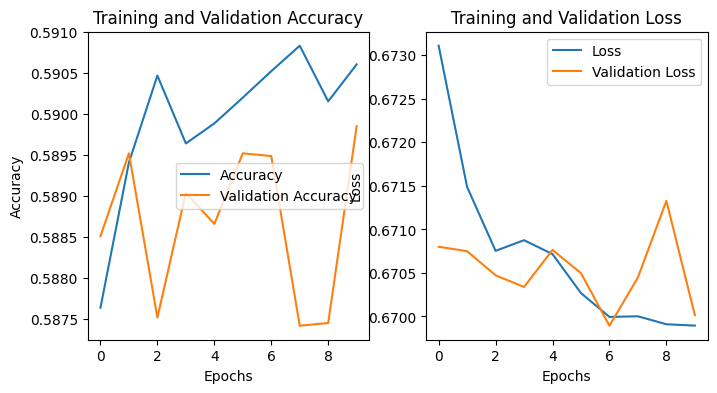

In [32]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

No Duplicado       0.59      0.57      0.58     37562
   Duplicado       0.59      0.62      0.60     37849

    accuracy                           0.59     75411
   macro avg       0.59      0.59      0.59     75411
weighted avg       0.59      0.59      0.59     75411



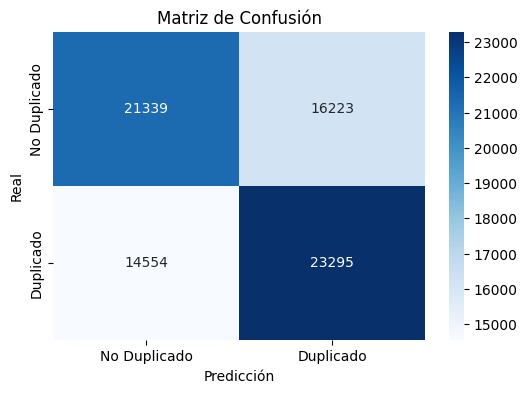

In [33]:
# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)